# Plot ampl. modulace pro axialni EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)


my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

#---------- odecet pozadi
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio = fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin = bg_ph_sum/(fotkor_shape[0]-2 + last_bin_ratio)

fotkor_bezcond[:fotkor_shape[0]-2,:] = fotkor_bezcond[:fotkor_shape[0]-2,:] - bg_ph_per_bin 
fotkor_bezcond[fotkor_shape[0]-2,:] = fotkor_bezcond[fotkor_shape[0]-2,:] - bg_ph_per_bin * last_bin_ratio
# ------------------------------

In [3]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

In [4]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

Nafitovani histogramu, vcetne vah

In [5]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

hist_sigma = 80  # empiricky odhadnuto --- muze se zmenit
W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/30**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )

zkouska plotu

In [6]:
alpha_bezcond = (voltages_bezcond[:,0] - voltages_bezcond[:,1]) / (voltages_bezcond[:,0] + voltages_bezcond[:,1])
a = 0.000357087248516796
b = 0.0000614272209845667
c = 0.000214572720416111

z_bezcond = a* alpha_bezcond + b* alpha_bezcond**3 + c *alpha_bezcond**5

In [7]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

No handles with labels found to put in legend.


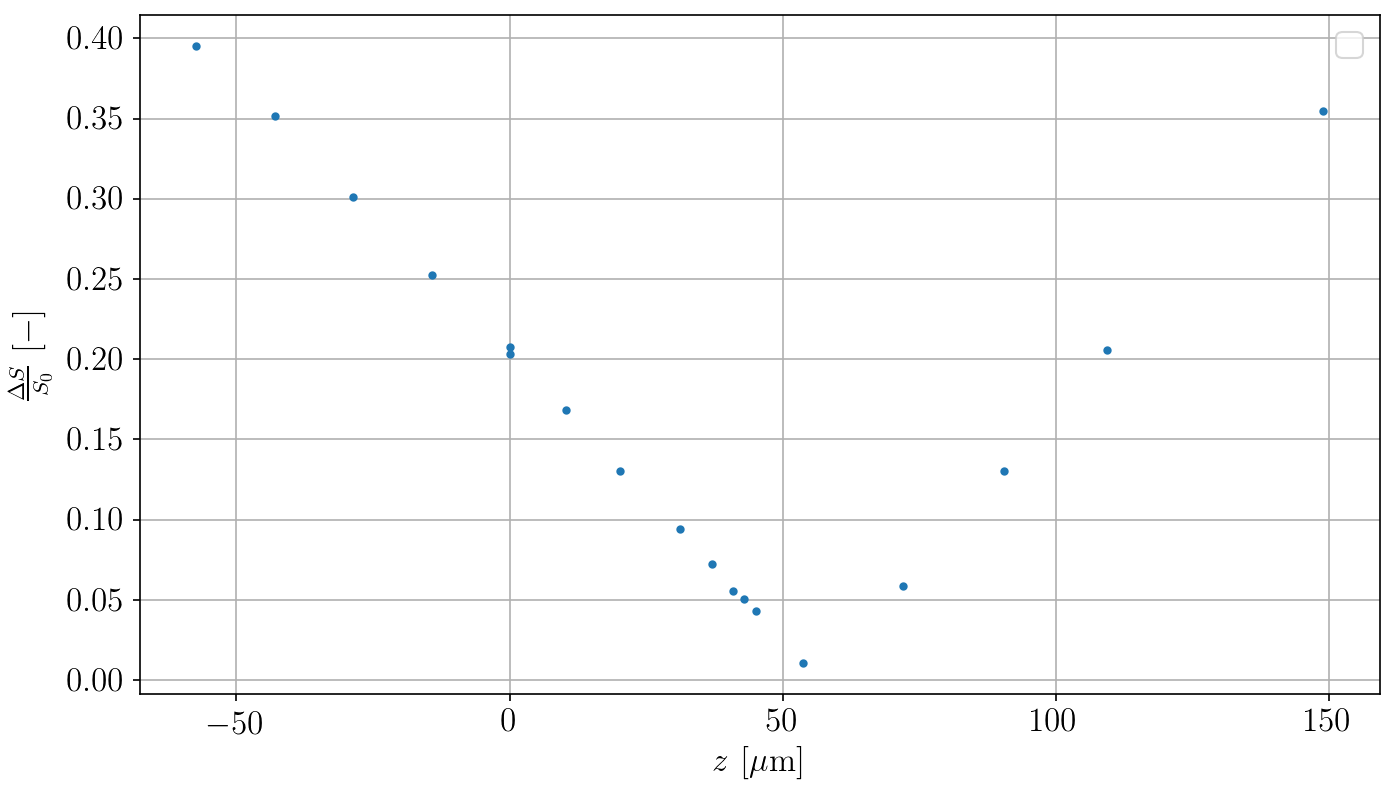

In [22]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(z_bezcond*1e6, np.abs(DeltaS_S_ratio), '.')
# plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()

zavislost nafituju primkou

In [3]:
# fce vracejici residua

def MM_resid(x, beta, z_points):
    return( beta - x[0] - x[1]*z_points )

def MM_line(x, z):
    return(x[0] + x[1]*z)

In [11]:
# fit zavislosti deltaS/S (z)

x0 = [0.06, -0.1]


fit = least_squares(MM_resid,x0, args=(DeltaS_S_ratio, z_bezcond) , ftol=1e-10, xtol=1e-10)
linfit_bezcond = fit.x


fit

 active_mask: array([0., 0.])
        cost: 0.00040663790549586834
         fun: array([-0.00636243, -0.0019722 , -0.00453051, -0.00261587, -0.00659986,
       -0.00601057, -0.00351281, -0.00557212, -0.00608343, -0.0051571 ,
       -0.00248672,  0.00161236,  0.00864267,  0.01264628,  0.0008831 ,
        0.00496425,  0.00657148,  0.01558347])
        grad: array([3.02333097e-09, 2.12084860e-13])
         jac: array([[-1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00, -1.04021217e-05],
       [-1.00000000e+00, -2.02237507e-05],
       [-1.00000000e+00, -3.12438718e-05],
       [-1.00000000e+00, -3.70106054e-05],
       [-1.00000000e+00, -4.09569751e-05],
       [-1.00000000e+00, -4.29619553e-05],
       [-1.00000000e+00, -4.51226849e-05],
       [-1.00000000e+00, -5.37866984e-05],
       [-1.00000000e+00, -7.19775312e-05],
       [-1.00000000e+00, -9.04411562e-05],
       [-1.00000000e+00, -1.09306121e-04],
       [-1.00000000e+00, -1.4

In [12]:
# ocekavany nulovy MM
z_fit = np.linspace(z_bezcond.min(), z_bezcond.max(), 200)
DeltaS_S_fit = MM_line(linfit_bezcond, z_fit)

z_MM_zero = - linfit_bezcond[0]/linfit_bezcond[1]  # expected MM zero
print("z_EMM_zero = ", z_MM_zero*1e6)

z_EMM_zero =  55.2270380386608


Mrknu jak to vypada

NameError: name 'z_fit' is not defined

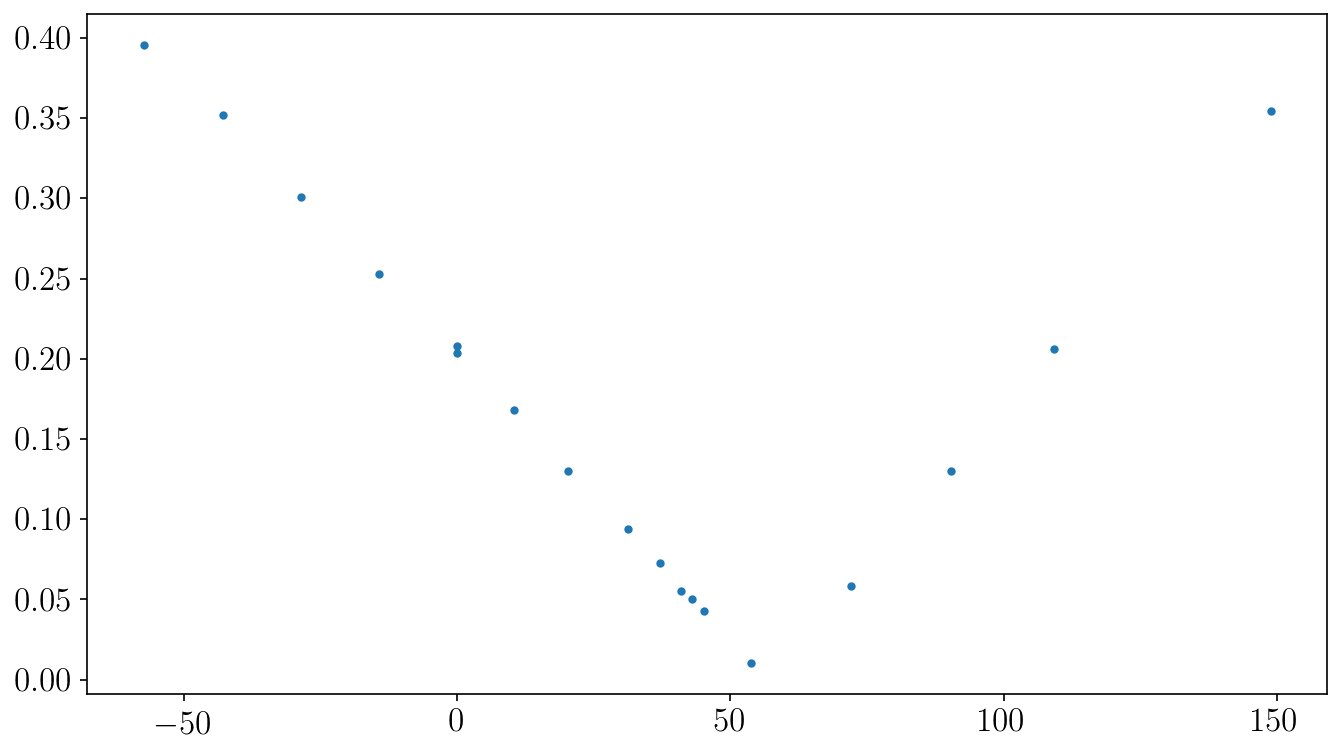

In [21]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(z_bezcond*1e6, np.abs(DeltaS_S_ratio), '.')
plt.plot(z_fit*1e6, np.abs(DeltaS_S_fit) )
# plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()

In [70]:
# fit zavislosti deltaS/S (\nu)

x0 = [0.06, -0.1]


fit = least_squares(MM_resid,x0, args=(DeltaS_S_ratio[5:12], alpha_bezcond[5:12]) , ftol=1e-10, xtol=1e-10)
linfit_bezcond_nu = fit.x


fit

 active_mask: array([0., 0.])
        cost: 6.146321798840223e-06
         fun: array([ 0.00045664,  0.00224433, -0.00016732, -0.00105146, -0.00153953,
       -0.00130207,  0.00135941])
        grad: array([-3.97617855e-10, -7.14415419e-12])
         jac: array([[-1.        , -0.10344828],
       [-1.        , -0.11442786],
       [-1.        , -0.12      ],
       [-1.        , -0.126     ],
       [-1.        , -0.15      ],
       [-1.        , -0.2       ],
       [-1.        , -0.25      ]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 3.976178553077858e-10
      status: 1
     success: True
           x: array([-0.21528602,  1.37608795])

In [80]:
# plot fitu deltaS/S(\nu) a bod s minimem EMM
nu_fit = np.linspace(alpha_bezcond[5:12].min(), alpha_bezcond[5:12].max(), 200)
DeltaS_S_fit_nu = MM_line(linfit_bezcond_nu, nu_fit)

nu_MM_zero = - linfit_bezcond_nu[0]/linfit_bezcond_nu[1]  # expected MM zero
print("nu_EMM_zero = ", nu_MM_zero)

nu_EMM_zero =  0.15644786059432159


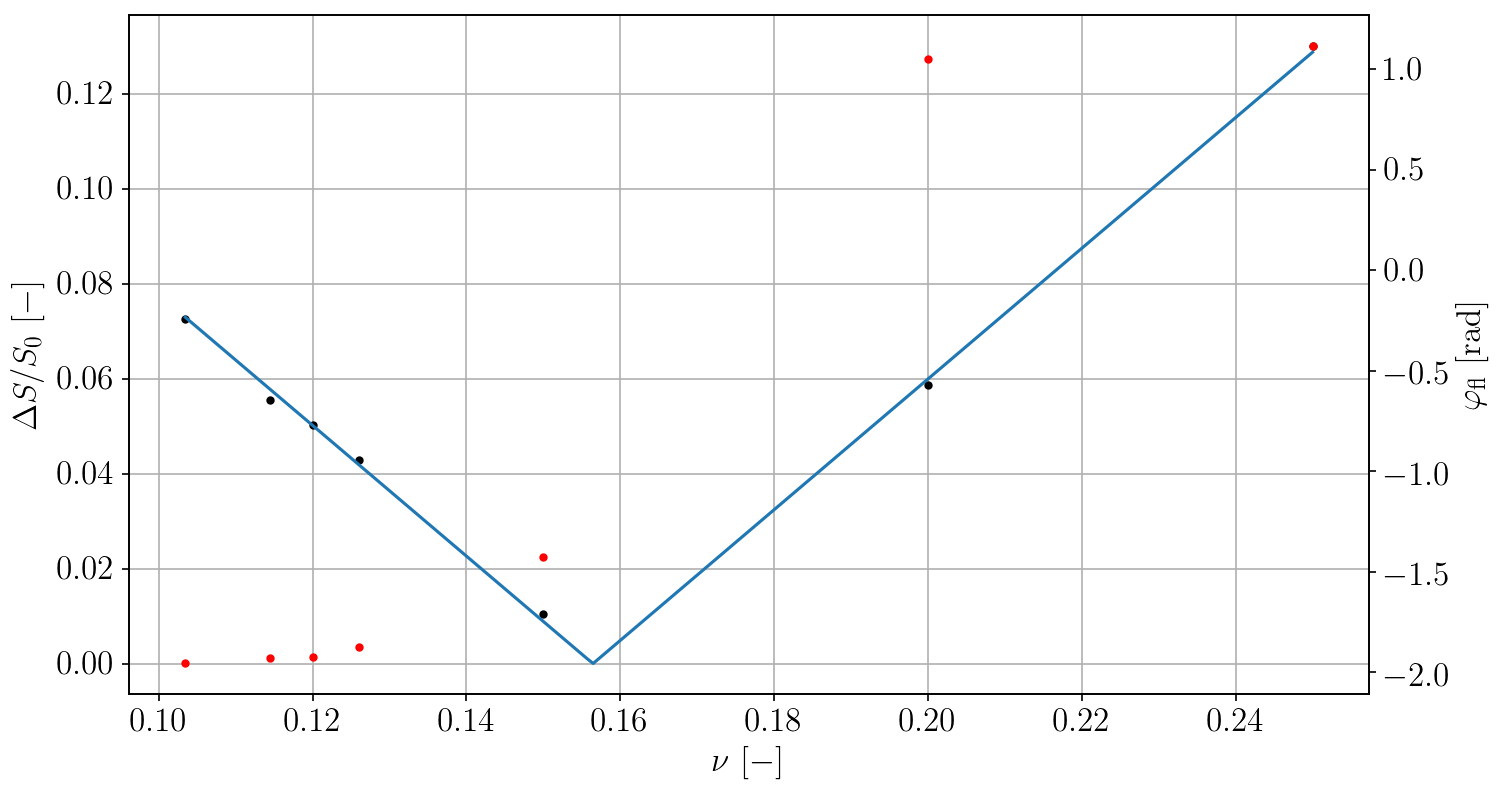

In [72]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1 = plt.gca()

ax1.plot(alpha_bezcond[5:12], np.abs(DeltaS_S_ratio[5:12]), '.', color='black')
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu))
ax2 = plt.twinx()

ax2.plot(alpha_bezcond[5:12], fot_phi[5:12], '.', color='red')
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")

# uprava os
#ax1.set_ylim(bottom=0, top=0.2)

# -------popisky

ax1.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax2.set_ylabel(r"$ \varphi_{\rm fl} \, \, \rm [rad]$")

# plt.legend()
ax1.grid()

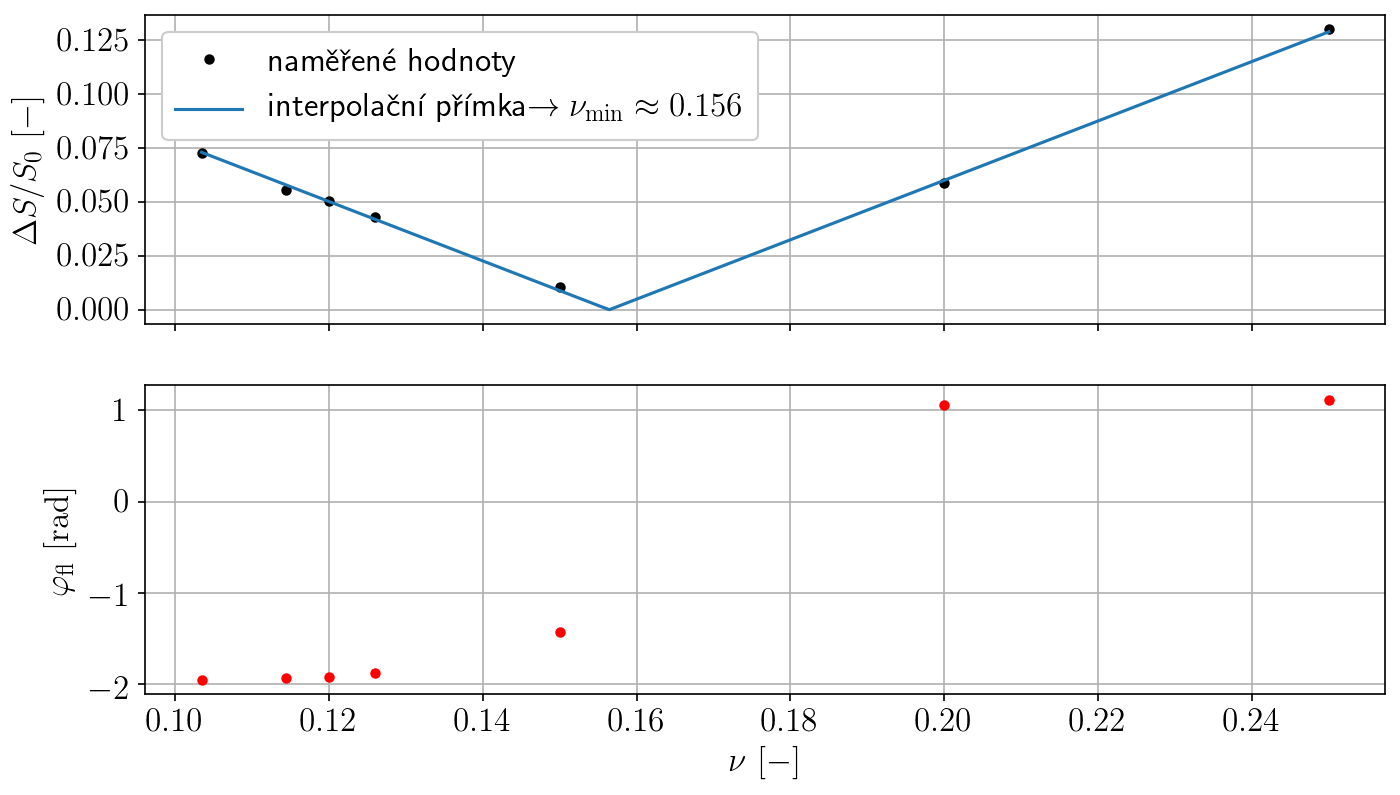

In [99]:
# f = plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

# ax1 = f.add_subplot(211)
# ax2 = f.add_subplot(212)

f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1.plot(alpha_bezcond[5:12], np.abs(DeltaS_S_ratio[5:12]), '.', color='black', markersize=8, label=r'naměřené hodnoty')
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'interpolační přímka'+r'$\rightarrow \nu_{{\rm min}} \approx {:.3f}$'.format(nu_MM_zero))
ax2.plot(alpha_bezcond[5:12], fot_phi[5:12], '.', color='red', markersize=8)
# ax2.errorbar(alpha_bezcond[5:12], fot_phi[5:12], yerr=sigmas[2,5:12],fmt='.')
# -------popisky

ax2.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax2.set_ylabel(r"$ \varphi_{\rm fl} \, \, \rm [rad]$")

# text1 = r'$ \nu_{{\rm min}} \approx {:.2f}$'.format(nu_MM_zero)
# ax1.text(0.2, max(DeltaS_S_ratio[5:12])-0.05,text1)

# ticky
ax1.set_yticks([0, 0.025, 0.05, 0.075, 0.1, 0.125])
# ax2.set_xticks([nu_MM_zero])
# xticks = ax1.get_xticks()
# xticks = sorted( np.append(xticks, nu_MM_zero) )
# ax1.set_xticks(xticks[1:-1 ])

ax1.grid()
ax2.grid()
ax1.legend(framealpha=1)

#savefigure
plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/ax_EMM_minim.svg", bbox_inches="tight")

## ilustrativni plot procesu minimalizace

In [18]:
[ alpha_bezcond[5],alpha_bezcond[11] ]
a = (DeltaS_S_ratio[11] - DeltaS_S_ratio[5])/(alpha_bezcond[11]- alpha_bezcond[5])
b = DeltaS_S_ratio[11] - a* alpha_bezcond[11]

In [24]:
# plot fitu deltaS/S(\nu) a bod s minimem EMM
nu_fit = np.linspace(alpha_bezcond[5], alpha_bezcond[11], 200)
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

nu_MM_zero = - b/a  # expected MM zero
print("nu_EMM_zero = ", nu_MM_zero)

nu_EMM_zero =  0.15588130497474878


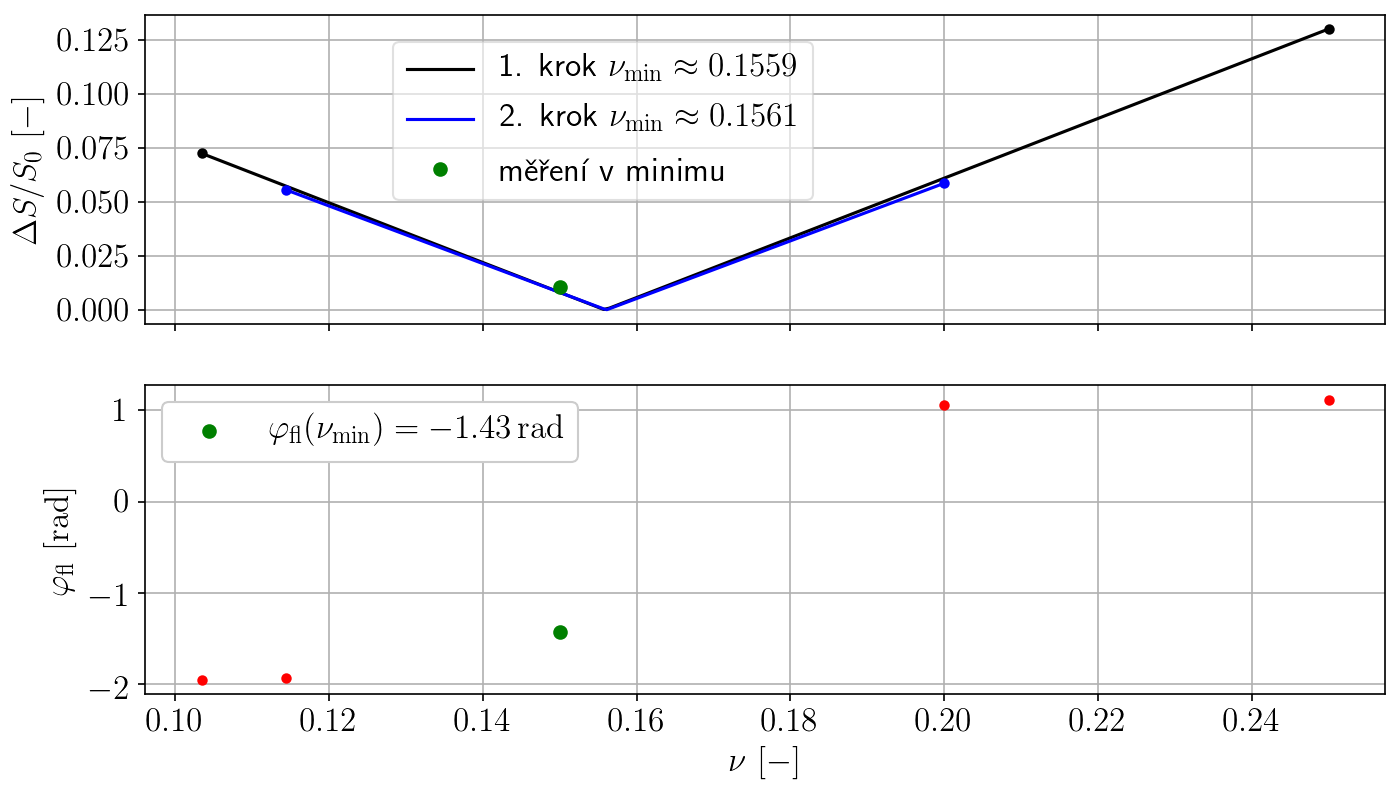

In [81]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

#---------vypocet interpolacnich primek
[ alpha_bezcond[5],alpha_bezcond[11] ]
a = (DeltaS_S_ratio[11] - DeltaS_S_ratio[5])/(alpha_bezcond[11]- alpha_bezcond[5])
b = DeltaS_S_ratio[11] - a* alpha_bezcond[11]

# plot fitu deltaS/S(\nu) a bod s minimem EMM
nu_fit = np.linspace(alpha_bezcond[5], alpha_bezcond[11], 200)
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

nu_MM_zero = - b/a  # expected MM zero

#-----------------------------


ax1.plot([ alpha_bezcond[5],alpha_bezcond[11] ], np.abs([ DeltaS_S_ratio[5],DeltaS_S_ratio[11] ]),
         '.', color='black', markersize=8)
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'1. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero), color='black')


####################---------dalsi dva body
#---------vypocet interpolacnich primek
[ alpha_bezcond[6],alpha_bezcond[10] ]
a = (DeltaS_S_ratio[10] - DeltaS_S_ratio[6])/(alpha_bezcond[10]- alpha_bezcond[6])
b = DeltaS_S_ratio[10] - a* alpha_bezcond[10]

# plot fitu deltaS/S(\nu) a bod s minimem EMM
nu_fit = np.linspace(alpha_bezcond[6], alpha_bezcond[10], 200)
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

nu_MM_zero = - b/a  # expected MM zero

#-----------------------------

#-----------plot techto bodu
ax1.plot([ alpha_bezcond[6],alpha_bezcond[10] ], np.abs([ DeltaS_S_ratio[6],DeltaS_S_ratio[10] ]),
         '.', color='blue', markersize=8)
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'2. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero), color='blue')
# ax1.plot(nu_MM_zero, 0, '+', color='blue')


########################

####################---------dalsi dva body
#---------vypocet interpolacnich primek
# [ alpha_bezcond[7],alpha_bezcond[9] ]
# a = (DeltaS_S_ratio[9] - DeltaS_S_ratio[7])/(alpha_bezcond[9]- alpha_bezcond[7])
# b = DeltaS_S_ratio[9] - a* alpha_bezcond[9]

# # plot fitu deltaS/S(\nu) a bod s minimem EMM
# nu_fit = np.linspace(alpha_bezcond[7], alpha_bezcond[9], 200)
# DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

# nu_MM_zero = - b/a  # expected MM zero

# #-----------------------------

# #-----------plot techto bodu
# ax1.plot([ alpha_bezcond[7],alpha_bezcond[9] ], np.abs([ DeltaS_S_ratio[7],DeltaS_S_ratio[9] ]),
#          '.', markersize=8)
# ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), label=r'$\rightarrow \nu_{{\rm min}} \approx {:.3f}$'.format(nu_MM_zero))



########################



# plot fazi

ax2.plot([alpha_bezcond[5],alpha_bezcond[6],alpha_bezcond[10],alpha_bezcond[11]], [fot_phi[5],fot_phi[6],fot_phi[10], fot_phi[11]], '.', color='red', markersize=8)
# ax2.errorbar(alpha_bezcond[5:12], fot_phi[5:12], yerr=sigmas[2,5:12],fmt='.')

#----------- plot mereni v minimu
ax1.plot(alpha_bezcond[9], np.abs( DeltaS_S_ratio[9] ), 'o', color='green', label=r'měření v minimu')
ax2.plot(alpha_bezcond[9], fot_phi[9], 'o', color='green', label=r'$\varphi_{{\rm fl}}(\nu_{{\rm min}}) = {:.2f}\,\rm rad$'.format(fot_phi[9]))

# -------popisky

ax2.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax2.set_ylabel(r"$ \varphi_{\rm fl} \, \, \rm [rad]$")

# text1 = r'$ \nu_{{\rm min}} \approx {:.2f}$'.format(nu_MM_zero)
# ax1.text(0.2, max(DeltaS_S_ratio[5:12])-0.05,text1)

# ticky
ax1.set_yticks([0, 0.025, 0.05, 0.075, 0.1, 0.125])
# ax2.set_xticks([nu_MM_zero])
# xticks = ax1.get_xticks()
# xticks = sorted( np.append(xticks, nu_MM_zero) )
# ax1.set_xticks(xticks[1:-1 ])

ax1.grid()
ax2.grid()
ax1.legend(framealpha=0.6, loc=(0.20,0.4))
ax2.legend(framealpha=1)
# plt.legend()
#plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/ax_EMM_minim_proces.svg", bbox_inches="tight")

# Data z mereni 3.5.2020

In [15]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_p1 = np.genfromtxt("03_05_20_EMM_min_z_step1_delim.txt", delimiter="\t")[:,:-1]
voltages_p1 = np.genfromtxt("03_05_20_EMM_min_z_step1_voltages.txt", delimiter="\t")
data_p2 = np.genfromtxt("03_05_20_EMM_min_z_step2_delim.txt", delimiter="\t")[:,:-1]
voltages_p2 = np.genfromtxt("03_05_20_EMM_min_z_step2_voltages.txt", delimiter="\t")
data_p3 = np.genfromtxt("03_05_20_EMM_min_z_step3_delim.txt", delimiter="\t")[:,:-1]
voltages_p3 = np.genfromtxt("03_05_20_EMM_min_z_step3_voltages.txt", delimiter="\t")
data_p4 = np.genfromtxt("03_05_20_EMM_min_z_step4_delim.txt", delimiter="\t")[:,:-1]
voltages_p4 = np.genfromtxt("03_05_20_EMM_min_z_step4_voltages.txt", delimiter="\t")
data_p5 = np.genfromtxt("03_05_20_EMM_min_z_final_delim.txt", delimiter="\t")[:,:-1]
voltages_p5 = np.genfromtxt("03_05_20_EMM_min_z_final_voltages.txt", delimiter="\t")

fotkor=np.concatenate( (data_p1 ,data_p2, data_p3, data_p4, data_p5) ,axis=1)
voltages=np.concatenate( (voltages_p1 ,voltages_p2, voltages_p3, voltages_p4, voltages_p5) ,axis=0)[:-1, :]

# pomocne promene
fotkor_shape = np.shape(fotkor)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = [90, 80, 100, 100, 95, 95, 95, 95, 95, 100, 100, 100, 100, 100] # doba nacitani dat v s
background_photocounts = [170, 170, 180, 170, 190, 190, 190, 190, 190, 180, 180, 180, 190, 190] # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody

# celkovy pocet fotonu:
# photon_sum = np.sum(fotkor, axis=0) - t_measure * background_photocounts
photon_sum = np.sum(fotkor, axis=0) - np.array(t_measure) * np.array(background_photocounts)

hist_sigma = 0.09088658 * np.sqrt( photon_sum )
# casova skala foton-kor. dat
# t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

#------fit 
from EMM_min_func import get_hist_fit

DeltaS_S_ratio, Delta_S_S_ratio_sigma, fot_phi, fot_phi_sigma, x, Omega, Omega_sigma, nu, t_scale = get_hist_fit(fotkor, 
                                                                                                    voltages, t_res, t_measure, 
                                                                                                    background_photocounts, hist_sigma, 
                                                                                                       sign_DeltaS=True)


In [16]:
from EMM_min_func import get_DeltaS_S_nu_fit

U_5, U_6, min_interv, linfit, nu_fit, DeltaS_S_fit_nu = get_DeltaS_S_nu_fit(DeltaS_S_ratio[4:], nu[4:], iter_coef=0.2)

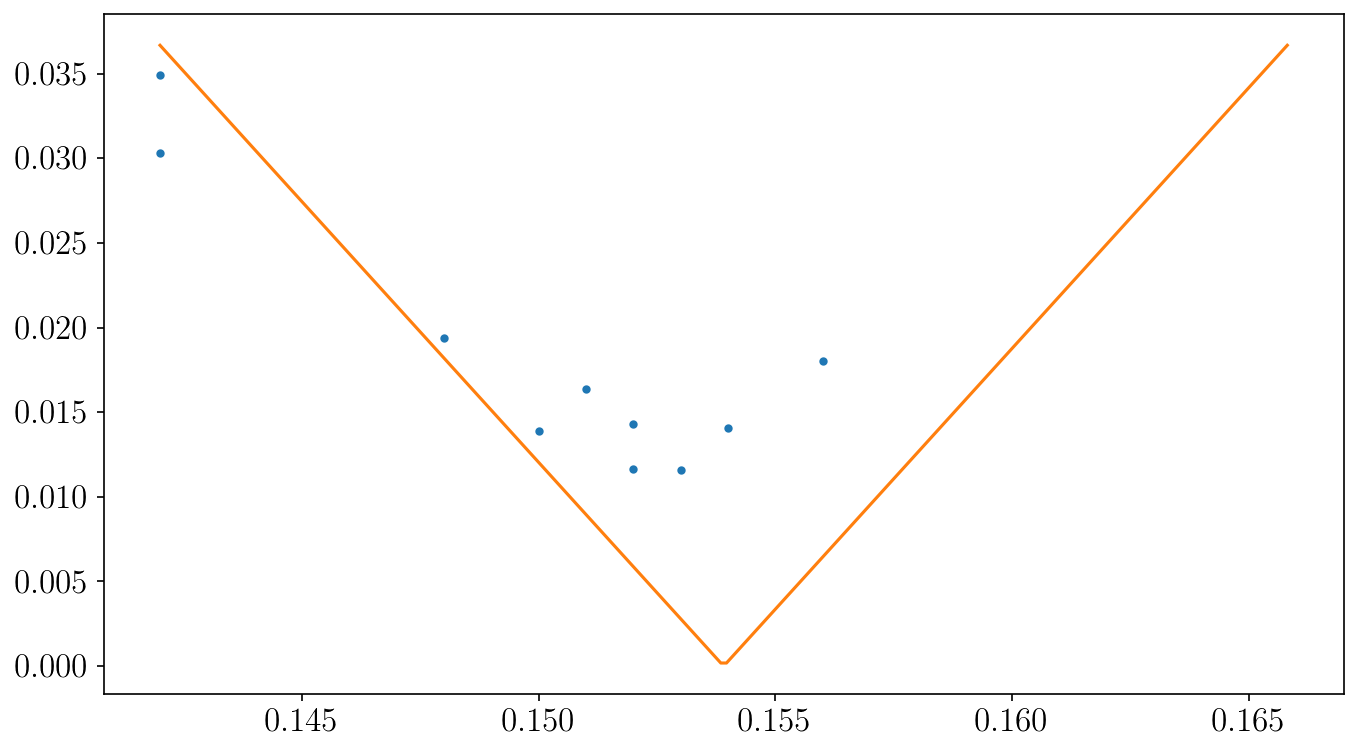

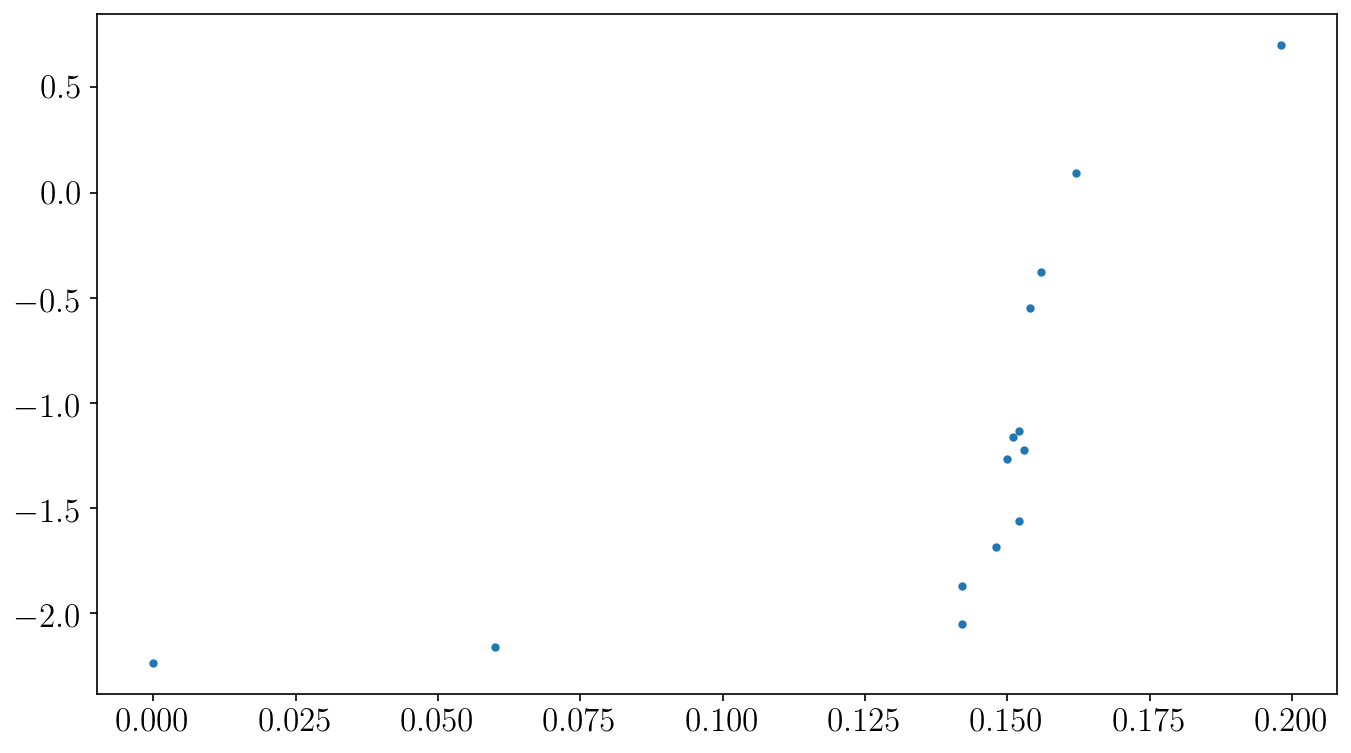

In [17]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(nu[4:], np.abs(DeltaS_S_ratio[4:]), '.')
plt.plot(nu_fit, np.abs(DeltaS_S_fit_nu) )

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(nu, fot_phi, '.')

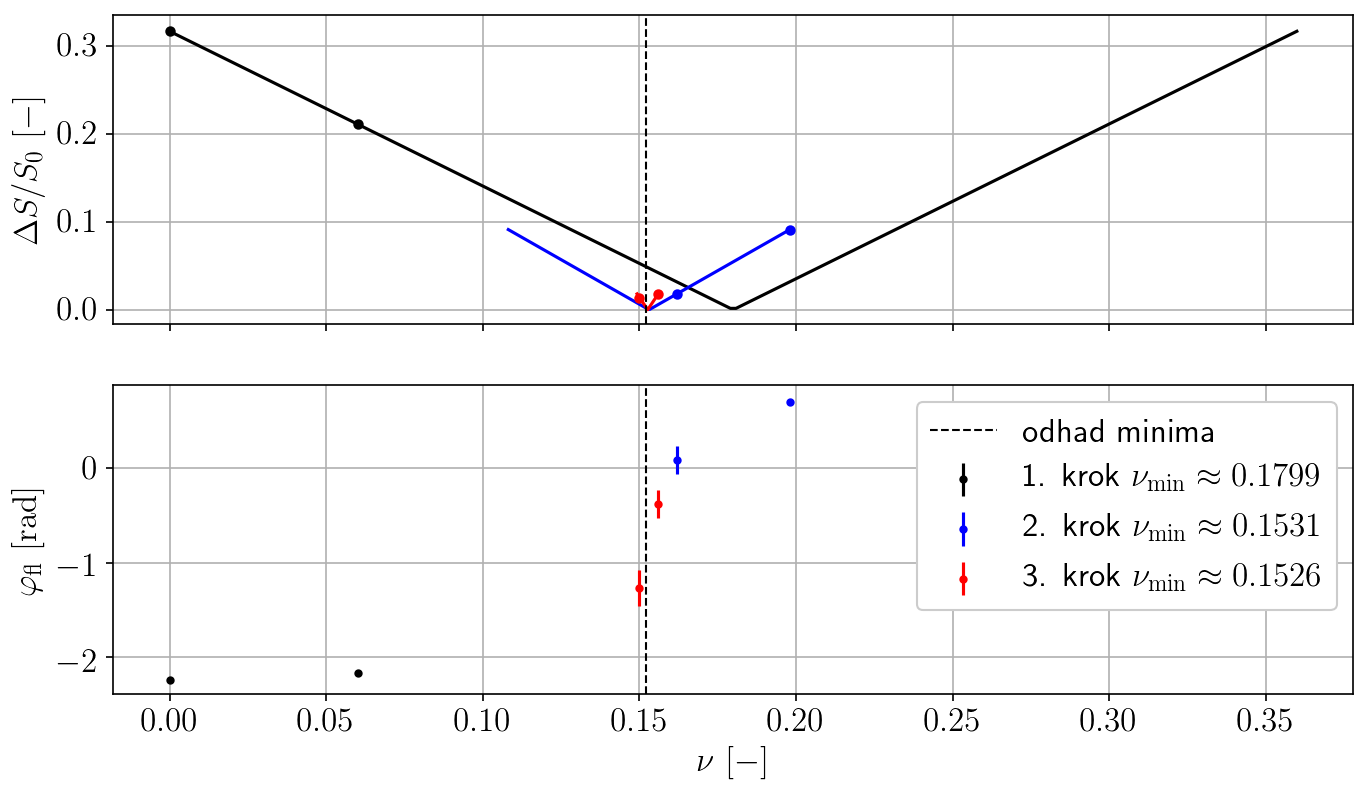

In [18]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

# #----nejistota v napetich cca
# sigma_nu = 0.005

#---------vypocet interpolacnich primek
[ nu[5],nu[11] ]
a = (DeltaS_S_ratio[0] - DeltaS_S_ratio[1])/(nu[0]- nu[1])
b = DeltaS_S_ratio[0] - a* nu[0]

# plot fitu deltaS/S(\nu) a bod s minimem EMM
# nu_fit = np.linspace(nu[0], nu[1], 200)
nu_MM_zero = - b/a  # expected MM zero
nu_fit = np.linspace(nu_MM_zero - np.max( np.abs(nu[:2] - nu_MM_zero) ), nu_MM_zero + np.max( np.abs(nu[:2] - nu_MM_zero) ), 200 ) 
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)



#-----------------------------


ax1.errorbar([ nu[0],nu[1] ], np.abs([ DeltaS_S_ratio[0],DeltaS_S_ratio[1] ]),
         fmt='.', color='black', markersize=8, yerr=Delta_S_S_ratio_sigma[:2])
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), color='black')
ax2.errorbar(nu[:2], fot_phi[:2], yerr=fot_phi_sigma[:2],fmt='.', color='black', label=r'1. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero))

####################---------dalsi dva body
#---------vypocet interpolacnich primek
a = (DeltaS_S_ratio[2] - DeltaS_S_ratio[3])/(nu[2]- nu[3])
b = DeltaS_S_ratio[2] - a* nu[2]

# plot fitu deltaS/S(\nu) a bod s minimem EMM
# nu_fit = np.linspace(nu[0], nu[1], 200)
nu_MM_zero = - b/a  # expected MM zero
nu_fit = np.linspace(nu_MM_zero - np.max( np.abs(nu[2:4] - nu_MM_zero) ), nu_MM_zero + np.max( np.abs(nu[2:4] - nu_MM_zero) ), 200 ) 
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

# #-----------------------------

# #-----------plot techto bodu
ax1.errorbar(nu[2:4], np.abs(DeltaS_S_ratio[2:4]),
         fmt='.', color='blue', markersize=8, yerr=Delta_S_S_ratio_sigma[2:4])
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), color='blue')
# ax1.plot(nu_MM_zero, 0, '+', color='blue')
ax2.errorbar(nu[2:4], fot_phi[2:4], yerr=fot_phi_sigma[2:4],fmt='.', color='blue', label=r'2. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero))

########################

####################---------dalsi dva body
#---------vypocet interpolacnich primek
a = (DeltaS_S_ratio[4] - DeltaS_S_ratio[5])/(nu[4]- nu[5])
b = DeltaS_S_ratio[4] - a* nu[4]

# plot fitu deltaS/S(\nu) a bod s minimem EMM
# nu_fit = np.linspace(nu[0], nu[1], 200)
nu_MM_zero = - b/a  # expected MM zero
nu_fit = np.linspace(nu_MM_zero - np.max( np.abs(nu[4:6] - nu_MM_zero) ), nu_MM_zero + np.max( np.abs(nu[4:6] - nu_MM_zero) ), 200 ) 
DeltaS_S_fit_nu = MM_line([b,a], nu_fit)

# #-----------------------------

# #-----------plot techto bodu
ax1.errorbar(nu[4:6], np.abs(DeltaS_S_ratio[4:6]),
         fmt='.', color='red', markersize=8, yerr=Delta_S_S_ratio_sigma[4:6])
ax1.plot(nu_fit, np.abs(DeltaS_S_fit_nu), color='red')
ax2.errorbar(nu[4:6], fot_phi[4:6], yerr=fot_phi_sigma[4:6],fmt='.', color='red', label=r'3. krok ' + r'$\nu_{{\rm min}} \approx {:.4f}$'.format(nu_MM_zero))


########################



# plot fazi

# ax2.plot([nu[0],nu[6],alpha_bezcond[10],alpha_bezcond[11]], [fot_phi[5],fot_phi[6],fot_phi[10], fot_phi[11]], '.', color='red', markersize=8)




#----------- plot mereni v minimu
# ax1.plot(alpha_bezcond[9], np.abs( DeltaS_S_ratio[9] ), 'o', color='green', label=r'měření v minimu')
# ax2.plot(alpha_bezcond[9], fot_phi[9], 'o', color='green', label=r'$\varphi_{{\rm fl}}(\nu_{{\rm min}}) = {:.2f}\,\rm rad$'.format(fot_phi[9]))
# ax2.errorbar(nu[10], fot_phi[10], fmt='.', color='green',
#           yerr = fot_phi_sigma[10], markersize=12, label=r"odhad minima")

ax2.axvline(nu[10], linestyle='--', linewidth=1, color='black', label=r"odhad minima")
ax1.axvline(nu[10], linestyle='--', linewidth=1, color='black')
# -------popisky

ax2.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax2.set_ylabel(r"$ \varphi_{\rm fl} \, \, \rm [rad]$")

# text1 = r'$ \nu_{{\rm min}} \approx {:.2f}$'.format(nu_MM_zero)
# ax1.text(0.2, max(DeltaS_S_ratio[5:12])-0.05,text1)

# ticky
# ax1.set_yticks([0, 0.025, 0.05, 0.075, 0.1, 0.125])
# ax2.set_xticks([nu_MM_zero])
# xticks = ax1.get_xticks()
# xticks = sorted( np.append(xticks, nu_MM_zero) )
# ax1.set_xticks(xticks[1:-1 ])

ax1.grid()
ax2.grid()
# ax1.legend(framealpha=0.6, loc=(0.20,0.4))
ax2.legend(framealpha=1)
# plt.legend()
# plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/ax_EMM_minim_proces_03_05_2020.svg", bbox_inches="tight")

In [19]:
# minimum v
print(DeltaS_S_ratio[-1])
print(Delta_S_S_ratio_sigma[-1])
print(fot_phi[-1])
print(nu[-1])

0.014321943394489063
0.002609309968393354
-1.1326961420489297
0.152


In [20]:
Omega

188726175.64876518

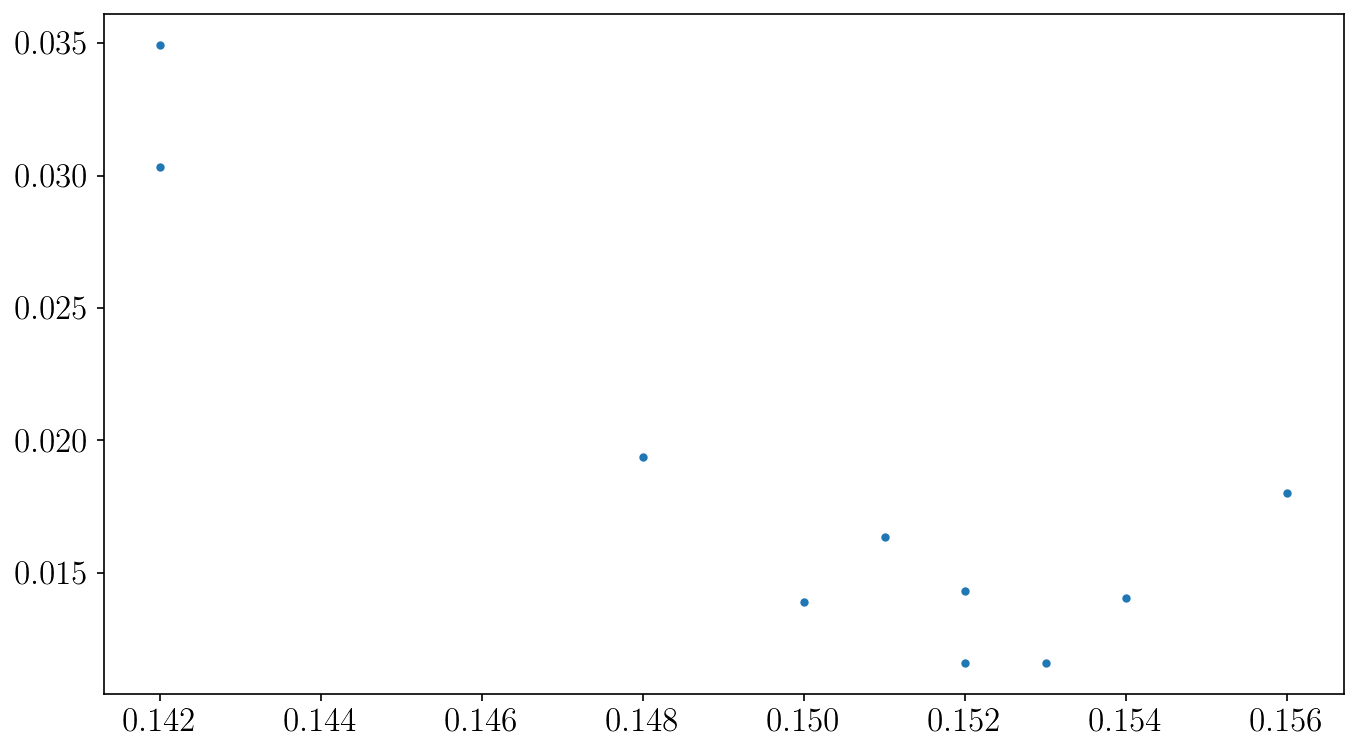

In [21]:
# from EMM_min_func import get_DeltaS_S_nu_fit

# U_5, U_6, min_interv, linfit, nu_fit, DeltaS_S_fit_nu = get_DeltaS_S_nu_fit(DeltaS_S_ratio[4:], nu[4:], iter_coef=0.2)

plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.plot(nu[4:], np.abs(DeltaS_S_ratio[4:]), '.')
# plt.plot(nu_fit, np.abs(DeltaS_S_fit_nu) )

In [22]:
from scipy.optimize import approx_fprime, check_grad

def root_func(x):
    [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

def root_func_grad(x):
#     [beta, norm_mod_amp, Omega, laser_detun, decay_rate] = x
    epsilon = 5e-6
    return( approx_fprime(x, root_func, x*epsilon ) )

In [23]:
# ---- napocitam si i bety
from EMM_min_func import get_beta, fl_signal

# parametry vypoctu beta

decay_rate = 2*np.pi * 21.008e6  # decay rate dle tabulek NISTu
laser_detun = -31e6 * 2*np.pi  # detuning 
laser_detun_sigma = 4e6 * 2*np.pi # sigma detun

# get beta
beta = np.zeros(fotkor_shape[1])
beta_sigma = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]-1):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, np.abs(DeltaS_S_ratio[k]) )
    
    # get sigma beta
    jacob_F = root_func_grad( np.array([beta[k], np.abs(DeltaS_S_ratio[k]), Omega, laser_detun, decay_rate]) ) 
    # [dF/dbeta, dF/ddeltaS/S, dF/dOmega, dF/dDelta, dF/dGamma]
    
    # variance-cov parametru
    Sigma_param = np.diag([Delta_S_S_ratio_sigma[k]**2, Omega_sigma**2, laser_detun_sigma**2])
    
    beta_sigma[k] = np.sqrt( jacob_F[0]**-2 * jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] ) )

beta[-1] = get_beta(Omega, decay_rate, -32e6 * 2*np.pi, np.abs(DeltaS_S_ratio[-1]) )

# get sigma beta
jacob_F = root_func_grad( np.array([beta[-1], np.abs(DeltaS_S_ratio[-1]), Omega, -32e6 * 2*np.pi, decay_rate]) ) 
# [dF/dbeta, dF/ddeltaS/S, dF/dOmega, dF/dDelta, dF/dGamma]

# variance-cov parametru
Sigma_param = np.diag([Delta_S_S_ratio_sigma[-1]**2, Omega_sigma**2, laser_detun_sigma**2])

beta_sigma[-1] = np.sqrt( jacob_F[0]**-2 * jacob_F[1:-1] @ Sigma_param @ np.transpose( jacob_F[1:-1] ) )
    

In [24]:
beta

array([0.11441019, 0.07495339, 0.00635747, 0.03203542, 0.00632442,
       0.00487697, 0.01225304, 0.01064477, 0.00492684, 0.00679289,
       0.00407465, 0.00573798, 0.00406954, 0.0050095 ])

In [25]:
beta_sigma

array([0.00337106, 0.00245052, 0.00095793, 0.00132922, 0.00096134,
       0.0009564 , 0.00100493, 0.00098941, 0.00097242, 0.00093473,
       0.000923  , 0.00093447, 0.00092253, 0.00091425])

array([0.00336623, 0.00245039, 0.0009712 , 0.00133079, 0.00096477,
       0.00096761, 0.00100151, 0.00098557, 0.00099974, 0.00093109,
       0.00091449, 0.00091731, 0.00090126, 0.00089944])

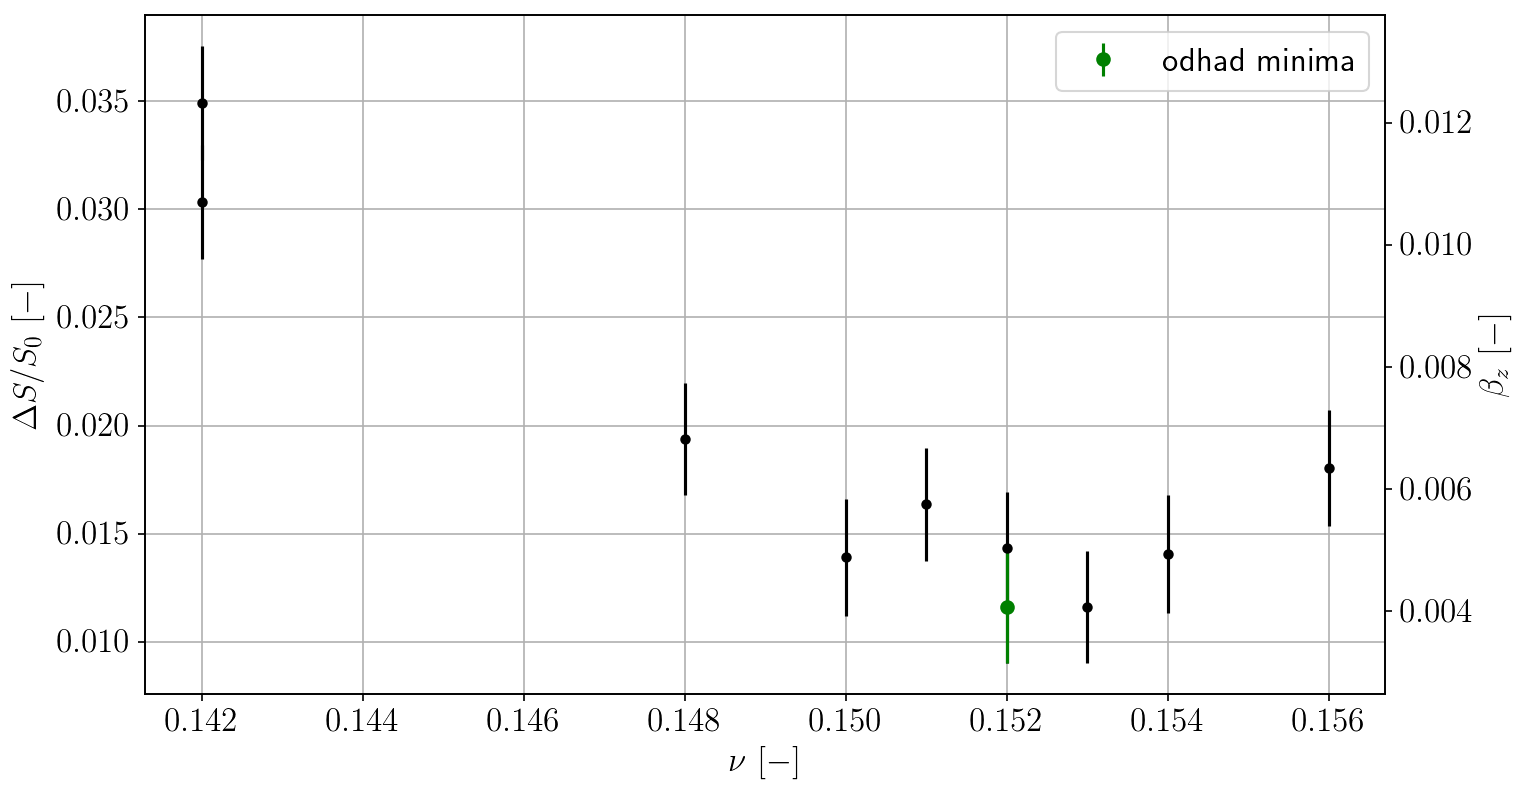

In [26]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
x = plt.gca()

x.errorbar(nu[4:], np.abs(DeltaS_S_ratio[4:]), fmt='.', color='black', yerr=Delta_S_S_ratio_sigma[4:], markersize=8)

#--- mereni v minimu
# x.errorbar(nu[np.argmin(beta)], np.abs(DeltaS_S_ratio[np.argmin(beta)]), fmt='.', color='green',
#           yerr = Delta_S_S_ratio_sigma[np.argmin(beta)], markersize=10)
x.errorbar(nu[10], np.abs(DeltaS_S_ratio[10]), fmt='.', color='green',
          yerr = Delta_S_S_ratio_sigma[10], markersize=12, label=r"odhad minima")

x2 = plt.twinx()
x2.errorbar(nu[4:], beta[4:], fmt='.', yerr=beta_sigma[4:], color='blue', alpha=0)
# x2.plot(nu[4:], beta[4:],'.', alpha=0)

# --- popisky
x.set_xlabel(r"$ \nu \, \, \rm [-]$")
x.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
x2.set_ylabel(r"$ \beta_z \, \, \rm [-] $")

x.legend()
x.grid()

#plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/ax_EMM_minim_proces_detail_03_05_2020.svg", bbox_inches="tight")

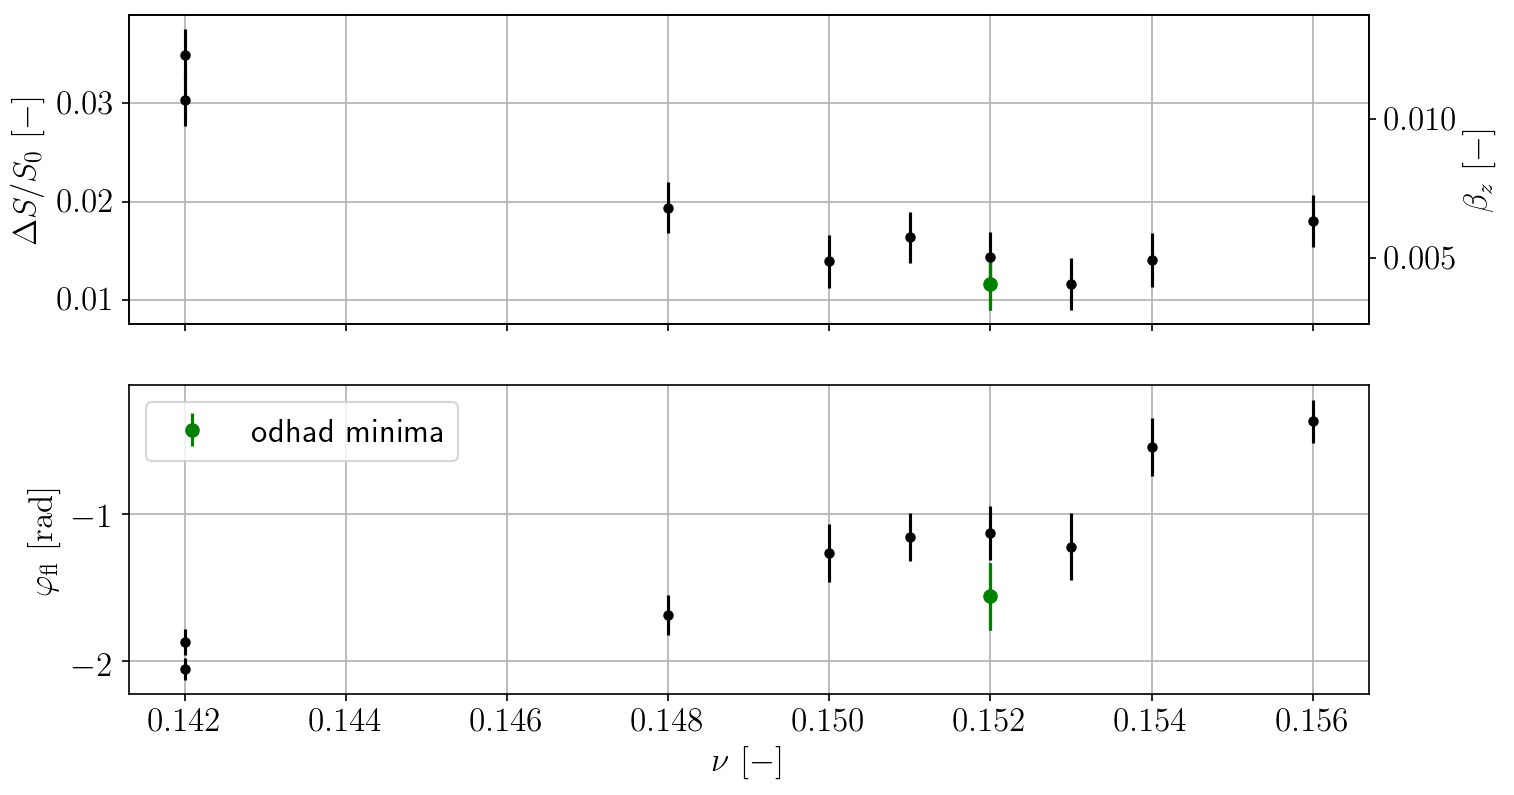

In [27]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1.errorbar(nu[4:], np.abs(DeltaS_S_ratio[4:]), fmt='.', color='black', yerr=Delta_S_S_ratio_sigma[4:], markersize=8)

#--- mereni v minimu
# x.errorbar(nu[np.argmin(beta)], np.abs(DeltaS_S_ratio[np.argmin(beta)]), fmt='.', color='green',
#           yerr = Delta_S_S_ratio_sigma[np.argmin(beta)], markersize=10)
ax1.errorbar(nu[10], np.abs(DeltaS_S_ratio[10]), fmt='.', color='green',
          yerr = Delta_S_S_ratio_sigma[10], markersize=12, label=r"odhad minima")

# plot hledane modulace
# ax1.axhline(DeltaS_S_ratio_xz_teor, linewidth=1, linestyle='--', color='blue')

ax12 = ax1.twinx()
# x2.errorbar(nu[4:], beta[4:], fmt='.', yerr=beta_sigma[4:], color='blue')
ax12.errorbar(nu[4:], beta[4:],fmt='.',
            yerr=beta_sigma[4:], alpha=0)

ax2.errorbar(nu[4:], fot_phi[4:], fmt='.', color='black', yerr=fot_phi_sigma[4:], markersize=8)

#--- mereni v minimu
# x.errorbar(nu[np.argmin(beta)], np.abs(DeltaS_S_ratio[np.argmin(beta)]), fmt='.', color='green',
#           yerr = Delta_S_S_ratio_sigma[np.argmin(beta)], markersize=10)
ax2.errorbar(nu[10], fot_phi[10], fmt='.', color='green',
          yerr = fot_phi_sigma[10], markersize=12, label=r"odhad minima")

# plot hledane modulace
# ax2.axhline(fot_phi_xz_teor, linewidth=1, linestyle='--', color='blue', label=r"hledaná modulace a fáze")


# --- popisky
ax2.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax12.set_ylabel(r"$ \beta_{z} \, \, \rm [-] $")
ax2.set_ylabel(r"$\varphi_{\rm fl} \, \, \rm [rad] $")

# ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()

# plt.savefig("/home/dan/diplomka_winfiles/Julia_vypocty_diplomka/julia_plots/ax_EMM_minim_proces_detail_03_05_2020.svg", bbox_inches="tight")

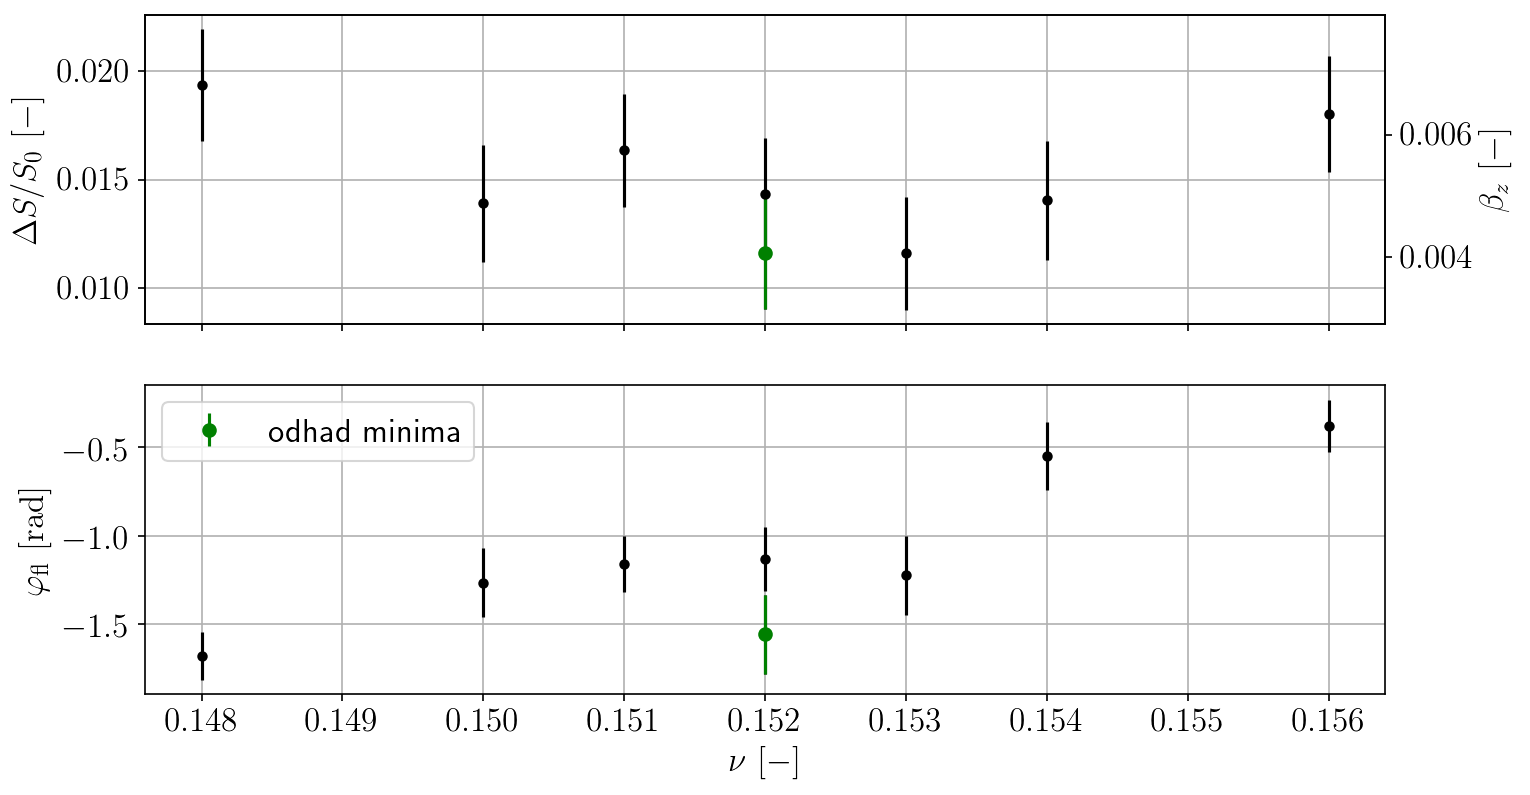

In [28]:
Delta_S_S_ratio_sigma = np.array(Delta_S_S_ratio_sigma)
fot_phi_sigma = np.array(fot_phi_sigma)
fot_phi = np.array(fot_phi)

f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)

ax1.errorbar(nu[[4,5,8,9,10,11,12,13]], np.abs(DeltaS_S_ratio[[4,5,8,9,10,11,12,13]]), fmt='.', color='black', yerr=Delta_S_S_ratio_sigma[[4,5,8,9,10,11,12,13]], markersize=8)

#--- mereni v minimu
# x.errorbar(nu[np.argmin(beta)], np.abs(DeltaS_S_ratio[np.argmin(beta)]), fmt='.', color='green',
#           yerr = Delta_S_S_ratio_sigma[np.argmin(beta)], markersize=10)
ax1.errorbar(nu[10], np.abs(DeltaS_S_ratio[10]), fmt='.', color='green',
          yerr = Delta_S_S_ratio_sigma[10], markersize=12, label=r"odhad minima")

# plot hledane modulace
# ax1.axhline(DeltaS_S_ratio_xz_teor, linewidth=1, linestyle='--', color='blue')

ax12 = ax1.twinx()
# x2.errorbar(nu[4:], beta[4:], fmt='.', yerr=beta_sigma[4:], color='blue')
ax12.errorbar(nu[[4,5,8,9,10,11,12,13]], beta[[4,5,8,9,10,11,12,13]],fmt='.',
            yerr=beta_sigma[[4,5,8,9,10,11,12,13]], alpha=0)

ax2.errorbar(nu[[4,5,8,9,10,11,12,13]], fot_phi[[4,5,8,9,10,11,12,13]], fmt='.', color='black', yerr=fot_phi_sigma[[4,5,8,9,10,11,12,13]], markersize=8)

#--- mereni v minimu
# x.errorbar(nu[np.argmin(beta)], np.abs(DeltaS_S_ratio[np.argmin(beta)]), fmt='.', color='green',
#           yerr = Delta_S_S_ratio_sigma[np.argmin(beta)], markersize=10)
ax2.errorbar(nu[10], fot_phi[10], fmt='.', color='green',
          yerr = fot_phi_sigma[10], markersize=12, label=r"odhad minima")

# plot hledane modulace
# ax2.axhline(fot_phi_xz_teor, linewidth=1, linestyle='--', color='blue', label=r"hledaná modulace a fáze")


# --- popisky
ax2.set_xlabel(r"$ \nu \, \, \rm [-]$")
ax1.set_ylabel(r"$ \Delta S / S_0 \, \, \rm [-]$")
ax12.set_ylabel(r"$ \beta_{z} \, \, \rm [-] $")
ax2.set_ylabel(r"$\varphi_{\rm fl} \, \, \rm [rad] $")

# ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()